Names:
1) Klaus Kades (Uni-id: fw448 Matrikelnr.: 3408463)

2) Lucas-Raphael Müller (Uni-id: al413 Matrikelnr.: 3205638)

3) Melanie Schellenberg (Uni-id: qh400 Matrikelnr.: 3146390)

4) Shuhan Xiao (Uni-id: kg410 Matrikelnr.: 3160697)


In [ ]:
import pandas as pd 
import networkx as nx 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np
from collections import Counter
import random

# Assignment 7
## Problem 7-3 Xalvi-Brunet and Sokolov Algorithm

### 1.
Implement a function to perform the Xalvi-Brunet and Sokolov algorithm on a given network.

In [209]:
def xalvi_brunet_sokolov_algorithm(G,n_iterations=100,assortative=True):
  G = G.copy()
  cont = 0
  for i in range(n_iterations):
    #print(f"it {i} {G.number_of_edges()}")
    edges = [e for e in G.edges]
    rnd_links = random.sample(edges,2)
    nodes = np.array([node for link in rnd_links for node in link])
    node_degrees = np.array([val for _, val in G.degree(nodes)])
    nodes = nodes[node_degrees.argsort()]
    # only perform step if no duplicate nodes are selected
    if len(np.unique(nodes)) == len(nodes): 
      if assortative:
        if (not G.has_edge(nodes[0],nodes[1])) and (not G.has_edge(nodes[2],nodes[3])):
          G.remove_edge(rnd_links[0][0], rnd_links[0][1])
          G.remove_edge(rnd_links[1][0], rnd_links[1][1])
          # rewire to increase assortativity
          G.add_edge(nodes[0], nodes[1])
          G.add_edge(nodes[2], nodes[3])
        else:
          continue # discard step if multiple edges would be created
      else:
        if (not G.has_edge(nodes[0],nodes[3])) and not(G.has_edge(nodes[1],nodes[2])):
          G.remove_edge(rnd_links[0][0], rnd_links[0][1])
          G.remove_edge(rnd_links[1][0], rnd_links[1][1])
          # rewire to increase disassortativity
          G.add_edge(nodes[0], nodes[3])
          G.add_edge(nodes[1], nodes[2])
        else:
          continue # discard step if multiple edges would be created
  print(cont)
  return G

### 2. 
Create two
additional networks using 5000 iterations of the Xalvi-Brunet and Sokolov algorithm: One network that
has been optimized for a high assortativity, and one optimized for disassortativity.

In [243]:
# load 
data = pd.read_csv(f'./neutral_network.txt', sep=r"\s+", index_col=None, names=['node1','node2'],)
print(data.shape)
display(data.head())
#print(data.shape)
G = nx.from_pandas_edgelist(data, source='node1',target='node2')
# convert to undirected graph
G = G.to_undirected()
print(G)

(294, 2)


,node1,node2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,6


Graph with 100 nodes and 294 edges


In [398]:
print(f"neutral network r={nx.degree_assortativity_coefficient(G)}")
# assortative network
Ga = xalvi_brunet_sokolov_algorithm(G, n_iterations=5000, assortative=True)
print(f"increased assortativity r={nx.degree_assortativity_coefficient(Ga)}")
print(Ga)


neutral network r=-0.00924626270173102
4326
increased assortativity r=0.7481758359324402
Graph with 100 nodes and 294 edges


In [399]:
# disassortative network
Gd = xalvi_brunet_sokolov_algorithm(G, n_iterations=5000, assortative=False)
print(f"increased disassortativity r={nx.degree_assortativity_coefficient(Gd)}")
print(Gd)

3874
increased disassortativity r=-0.8394536681115572
Graph with 100 nodes and 294 edges


### 3.
For all three networks, plot $P_{∞}(f)/P_{∞}(0)$. 

In [386]:
largest_cc = max(nx.connected_components(G), key=len)
print(len(largest_cc))

100


In [401]:
def get_relative_gc_size(G, n_samples=10, f_samples=21):
  fractions = np.linspace(0,1,f_samples)
  G = G.copy()
  N = G.number_of_nodes()
  Gc_0 = len(max(nx.connected_components(G), key=len))
  Gc_f = np.zeros((len(fractions),n_samples))
  for i in range(n_samples):
    for j, f in enumerate(fractions):
      G_ = G.copy()
      nodes = [n for n in G_.nodes]
      # remove f*N nodes
      if f > 0.0:
        rnd_nodes = random.sample(nodes,round(f*N))
        for n in rnd_nodes:
          G_.remove_node(n)
      cc = [len(c) for c in sorted(nx.connected_components(G_), key=len, reverse=True)]
      print(cc)
      largest_cc = max(cc) if len(cc)>0 else 0
      Gc_f[j,i] = largest_cc/Gc_0
  Gc_f = np.average(Gc_f,axis=1)
  return Gc_f, fractions


In [388]:
def plot_relative_gc_size(G, name=""):
  Gc_f, fractions = get_relative_gc_size(G, n_samples=50)
  plt.figure()
  plt.plot(fractions, Gc_f)
  plt.ylabel("$P_{\infty}(f)/P_{\infty}(0)$")
  plt.xlabel("fraction f")
  plt.title(f"Relative Size of Giant Component of {name} network")


Text(0.5, 1.0, 'Relative Size of Giant Component')

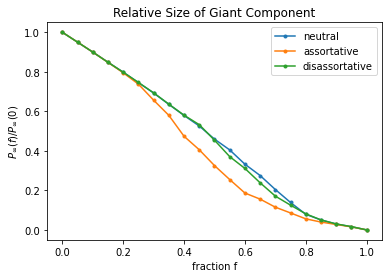

In [400]:
n_samples = 100
G_list = [G, Ga, Gd]
plt.figure()
for G_ in G_list:
  Gc_f, fractions = get_relative_gc_size(G_, n_samples=n_samples, f_samples=21)
  plt.plot(fractions, Gc_f, ".-")
plt.ylabel("$P_{\infty}(f)/P_{\infty}(0)$")
plt.xlabel("fraction f")
plt.legend(["neutral","assortative","disassortative"])
plt.title(f"Relative Size of Giant Component")


### 4.
Which network is the most robust against random failures?


The neutral network is the most robust against random failures, the disassortative network shows a similar behaviour (the green curve is slightly below the blue curve). A smaller fraction of nodes of the assortative network need to be removed to significantly decrease the size of the giant component, which can be seen in the above plot (the orange curve is lower, especially between f=0.4 and f=0.7), the assortative network is therefore less robust.


This can be explained by the fact that when high degree nodes are removed in assortative networks, also many other high degree nodes are affected (since high degree nodes are on average more likely to be connected to other high degree nodes in assortative networks). It is therefore possible, that by removing high degree nodes also the links between cluster of other nodes with high degrees are removed. Additionaly, it is also more likely for low degree nodes lose connection to the giant component, since they are mostly connected to ther low degree nodes, e.g. in long chains. The network easily becomes fragmented into smaller components, compared to disassortative or neutral networks.

